- Figure out which train datset is predicting which test dataset
- Make pandas table in order to be able to evaluate the different models that just combines them all

## All countries

This code uses spatial cross-validation to evaluate Random Forest, XGBoost and SVM models, by dividing the data into group folds according to the country in which the counter is found. 

In [45]:
import shap
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, GroupKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Data selection

In [48]:
#Load in data
#Import csv and remove non-numerical variables
df = pd.read_csv('/Users/winke/Documents/University/Thesis/Predicting_cycling/weekly_new.csv')
df = df.drop(['name', 'year', 'week', 'latitude', 'longitude', 'espg'] , axis=1)

df = df[['counts_week', 'country', 'dist_to_greenspace', 'dist_to_edu', 'bike_points', 'bus_stops', 'business_shops', 'traffic_signals', 'cycle_length', 'dem_std',
         'lst_mean', 'pop_sum', 'build_area', 'lc_entropy', 'ndvi_mean', 'dist_to_bikePOI', 'dist_to_train', '3_way_int_count', 'streets_per_node_avg', 'median_speed']]

country = df

#Create dependent and independent variable
y = country.loc[:,'counts_week']
X = country.drop(['counts_week', 'country'], axis=1)

# Normalize dependent variable
scaler = StandardScaler()
data_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
y = pd.Series(data_scaled.ravel())

Option 1: Spatial cross validation

In [16]:
#Create spatial cross-validation according to countries
k = GroupKFold(n_splits=3)
countries = country['country'].values 
country_kfold = k.split(X, y, countries)

# Create the nested list of train and test indices for each fold
train_indices, test_indices = [list(traintest) for traintest in zip(*country_kfold)]
city_cv = [*zip(train_indices,test_indices)]

Option 2: Regular train/test split

In [49]:
#Create traintestsplit for machine learning models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## Linear Regression (OLS)

In [40]:
#Add a constant to the data and run OLS regression
Xc = sm.add_constant(X)
Xc.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
model = sm.OLS(y, Xc).fit()

# Create a DataFrame with the X variables
X_df = pd.DataFrame(X, columns=X.columns)

# Compute the correlation matrix
corr_matrix = X_df.corr()

corr_matrix.to_csv('correlation_matrix.csv')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            counts_week   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     13.41
Date:                Sat, 18 Feb 2023   Prob (F-statistic):           7.54e-36
Time:                        23:33:44   Log-Likelihood:                -10827.
No. Observations:                 912   AIC:                         2.169e+04
Df Residuals:                     893   BIC:                         2.178e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.237e+04 

In [41]:
# Predict target variable using the OLS model
y_pred = model.predict(Xc)

# Calculate evaluation metrics
mse = mean_squared_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
mae = mean_absolute_error(y, y_pred)

# Print evaluation metrics
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  1199589552.321311
RMSE:  34635.09134275975
MAE:  18676.68530245017


In [42]:
Xnc = Xc.drop('const', axis=1)

#Check multicolinearity with VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(Xnc.values, i) for i in range(Xnc.shape[1])]
vif["features"] = Xnc.columns

print(vif)

          VIF              features
0    2.917413    dist_to_greenspace
1    3.474919           dist_to_edu
2    1.746521           bike_points
3    2.510693             bus_stops
4    1.644514        business_shops
5    2.733287       traffic_signals
6    3.897558          cycle_length
7    2.944560               dem_std
8   15.865061              lst_mean
9    2.410711               pop_sum
10   7.856205            build_area
11  35.164119            lc_entropy
12  10.511051             ndvi_mean
13   2.814229       dist_to_bikePOI
14   2.587460         dist_to_train
15   4.670403       3_way_int_count
16  31.478960  streets_per_node_avg
17   5.010194          median_speed


## Random Forest

With spatial cross validation

In [ ]:
# Define the parameter grid to search
param_grid = {'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [5, 10, 15, 20, 25],
            'min_samples_split': [2, 5, 10]}

# Iterate through the folds
for train_index, test_index in city_cv:
    # Use the indices to split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    trains = df.iloc[train_index]['country'].drop_duplicates().values
    test = df.iloc[test_index]['country'].drop_duplicates().values

    # Create the random forest model
    rf = RandomForestRegressor()

    # Create the K-fold cross-validation object
    kf = KFold(n_splits=2)

    # Create the grid search object
    grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring='neg_mean_squared_error')

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    #Run the model on the test split of the data
    y_pred = grid_search.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    
    #Calculate model statistics and print them
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    print("*** FOLD *** training: " + trains[0]+ " " + trains[1] + " | test: " + test[0])
    print("Fold score:", score)
    print("R-squared: ", r2)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAE: ", mae)

    # Print the best parameters and score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

With K-fold cross validation

In [47]:
# Define the parameter grid to search
param_grid = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [5, 10, 15, 20, 25],
            'min_samples_split': [2, 5, 10]}

# Create the random forest model
rf = RandomForestRegressor()

# Create the K-fold cross-validation object
kf = KFold(n_splits=5)

# Create the grid search object
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#Create model from best parameters
best_params = grid_search.best_params_
model_rf = RandomForestRegressor(**best_params)

#Run the model on the test split of the data
model_rf.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

#Calculate model statistics and print them
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

Best parameters:  {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best score:  -1169069552.1753812
R-squared:  0.558223184027856
MSE:  478110085.9299929
RMSE:  21865.728570756404
MAE:  10421.282550877635


## XGBOOST

With spatial cross validation

In [13]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid to search
param_grid = {'n_estimators': [50, 100, 200, 250, 300, 400],
              'max_depth': [3, 5, 10, 15],
              'learning_rate': [0.1, 0.3, 0.5, 1],
              'subsample': [0.8, 1],
              'colsample_bytree': [0.8, 1]
              }

# Iterate through the folds
for train_index, test_index in city_cv:
    # Use the indices to split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create the XGBoost model
    xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')
    
    # Create the grid search object
    grid_search = GridSearchCV(xgb_reg,
                   param_grid=param_grid,
                   scoring='neg_mean_squared_error',
                   verbose=True)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    #Run the model on the test split of the data
    y_pred = grid_search.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    
    #Calculate model statistics and print them
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    print("*** FOLD *** training: " + trains[0]+ " " + trains[1] + " | test: " + test[0])
    print("Fold score:", score)
    print("R-squared: ", r2)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAE: ", mae)

    # Print the best parameters and score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

NameError: name 'city_cv' is not defined

With regular K-Fold cross validation

In [50]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid to search
param_grid = {'n_estimators': [50, 100, 200, 250, 300],
              'max_depth': [3, 5, 10, 15],
              'learning_rate': [0.1, 0.3, 0.5, 1],
              'subsample': [0.8, 1],
              'colsample_bytree': [0.8, 1]
              }

# Create the XGBoost model
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')

# Create the K-fold cross-validation object
kf = KFold(n_splits=5)

# Create the grid search object
grid_search = GridSearchCV(xgb_reg,
                param_grid=param_grid,
                cv=kf,
                scoring='neg_mean_squared_error',
                verbose=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#Create model from best parameters
best_params = grid_search.best_params_
model_xgb = xgb.XGBRegressor(**best_params)

# Get the predictions of the model on the test data
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

# Calculate the R-squared, RMSE, MSE and F1-score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
# f1 = f1_score(y_test, y_pred > 0.5)

print("R-squared: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
# print("F1 score: ", f1)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best parameters:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Best score:  -0.7228523141229342
R-squared:  0.5414900755093162
MSE:  0.32562128266681795
RMSE:  0.5706323533298984
MAE:  0.289739524262559


In [5]:
# Save the trained model
with open('/Users/winke/Documents/University/Thesis/Predicting_cycling/models/saved_models/all_xgb.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)

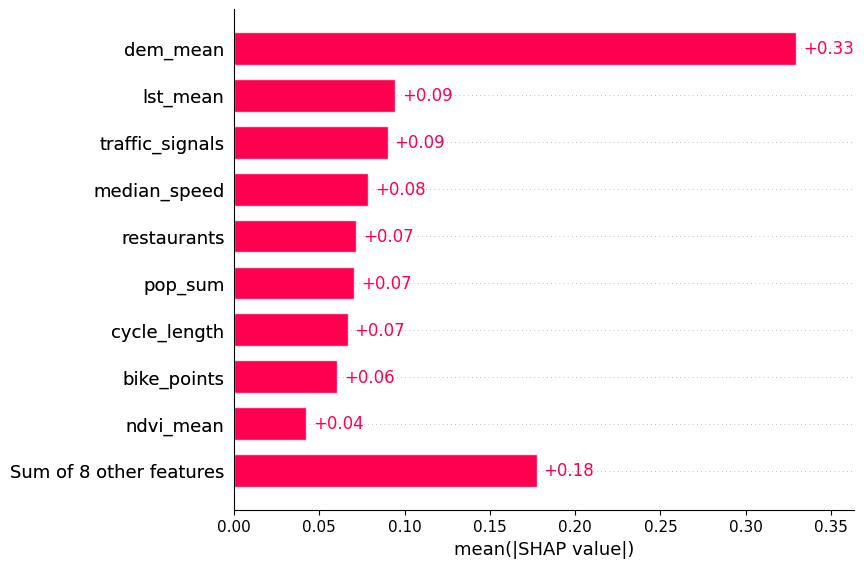

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


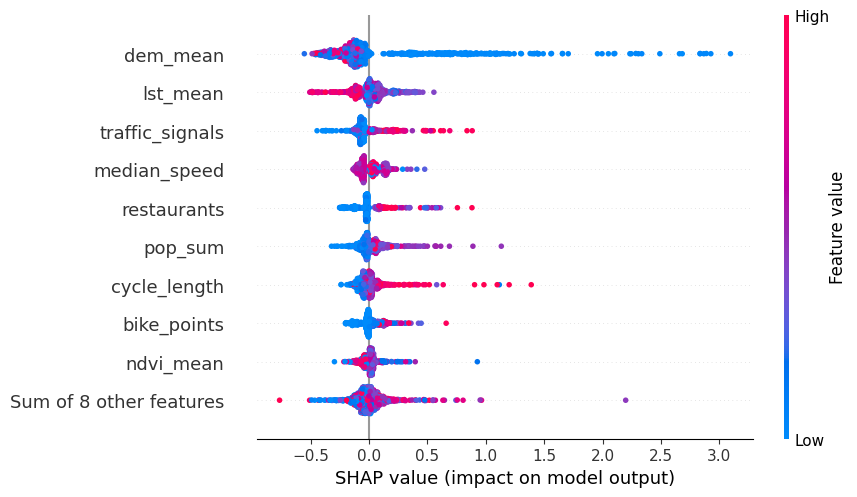

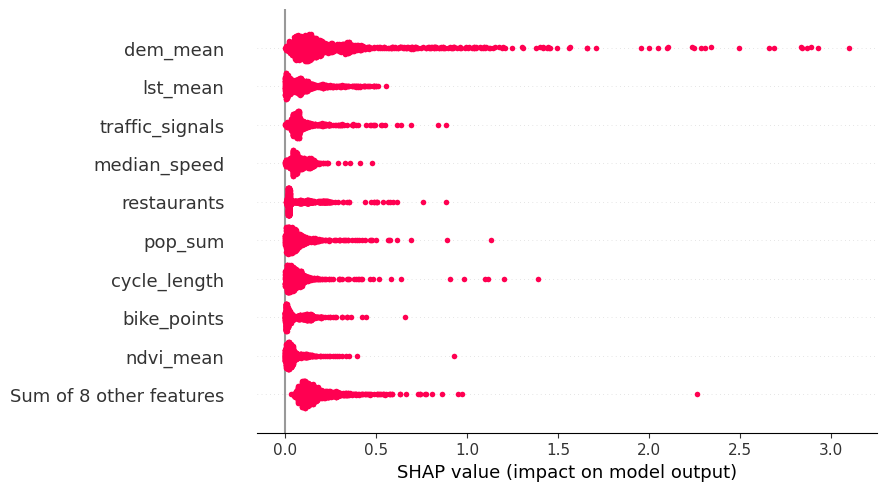

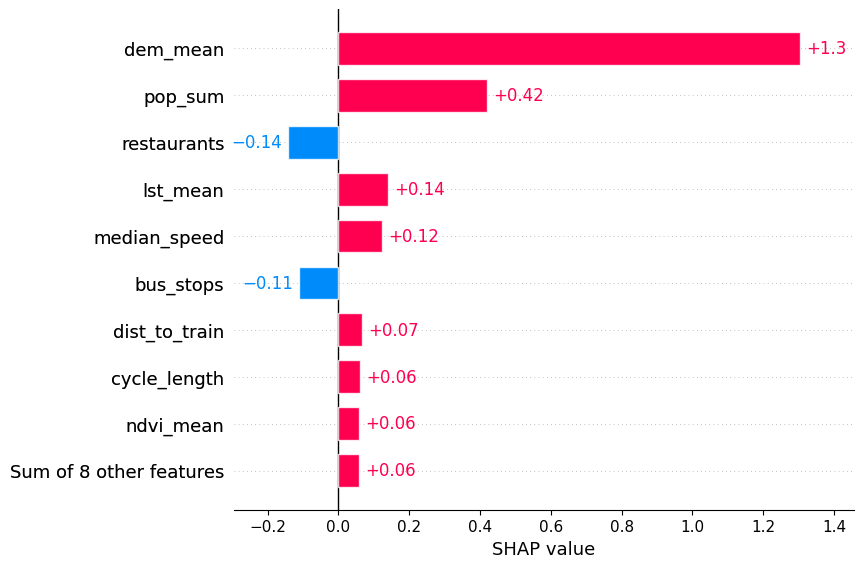

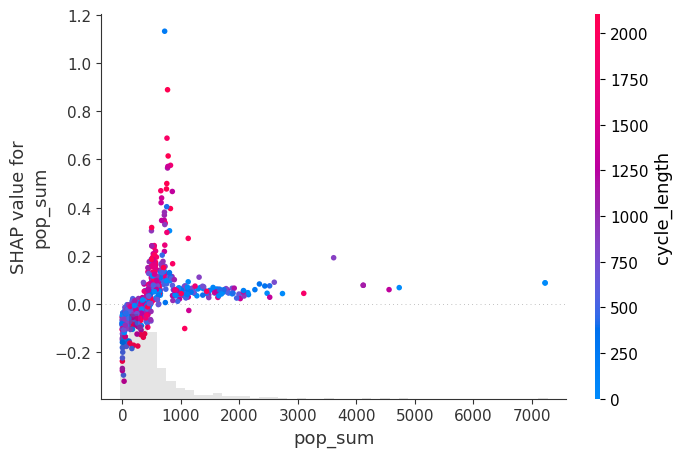

In [75]:
#Using SHAP to explain things
explainer = shap.Explainer(model_xgb, X_train)
shap_values = explainer(X)

# shap_values.display_data = shap.datasets.adult(display=True)[0].values
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

shap.plots.beeswarm(shap_values.abs, color="shap_red")

shap.plots.bar(shap_values[1])

shap.plots.scatter(shap_values[:,"pop_sum"], color=shap_values)

## SVM

With spatial cross validation

In [ ]:
from sklearn.svm import SVR

# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 1, 10],
              'kernel': ['linear', 'rbf']
              }

# Iterate through the folds
for train_index, test_index in city_cv:
    # Use the indices to split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create the SVM model
    svm = SVR()

    # Create the grid search object
    grid_search = GridSearchCV(svm,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    verbose=True)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    #Run the model on the test split of the data
    y_pred = grid_search.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    
    #Calculate model statistics and print them
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    print("*** FOLD *** training: " + trains[0]+ " " + trains[1] + " | test: " + test[0])
    print("Fold score:", score)
    print("R-squared: ", r2)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAE: ", mae)

    # Print the best parameters and score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

With regular K-fold cross validation

In [ ]:
# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1],
              'kernel': ['linear', 'rbf']
              }

# Create the SVM model
svm_reg = SVR()

# Create the K-fold cross-validation object
kf = KFold(n_splits=5)

# Create the grid search object
grid_search = GridSearchCV(svm_reg,
                param_grid=param_grid,
                cv=kf,
                scoring='neg_mean_squared_error',
                verbose=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#Create model from best parameters
best_params = grid_search.best_params_
model_svm = SVR(**best_params)

# Get the predictions of the model on the test data
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)

# Calculate the R-squared, RMSE, MSE and F1-score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)